In [9]:
import numpy as np
import scipy.spatial
from sklearn.neighbors import KDTree, BallTree
import matplotlib.pylab as plt
from scipy.stats import poisson, erlang
from scipy import interpolate
from os import urandom
import struct
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
plt.rcParams["figure.figsize"] = [16.34, 13]
plt.rc("text", usetex=True)
plt.rcParams["font.size"] = 12;

# Nearest Neighbor Density Statistics for Large Scale Structure Studies
**Tom Abel**, *Kavli Institute for Particle Astrophysics and Cosmology, Stanford*

### Abstract
> The Nearest Neighbor Density, $\rho_{kNN}$ is a often used as a density estimator and classifier. We advocate its use as a statistic to characterize spatial and labeled data. We show that it is very closely related to the so called Void Probability Function as well as Counts in Cell Statistics. In fact the probability density function of this density field for $k=1$, $PDF_{1NN}$ is the Void Probability function defined by White (1979). Interestingly $PDF_{kNN}$ as computed from Large Scale Structure data such as observed galaxies or simulated dark matter halos is very sensitive to how clustered the data is. We demonstrate this explicitly showing this statistic for a sample of halos from the Bolshoi simulations as well as a luminous red galaxy sample from the Sloan Digital Sky survey. The $PDF_{kNN}$ is efficiently computed using KD-trees. In contrast to the standard two point correlation functions and powerspectra measured from such data it does not have to be binned and every sample (distance to the $k$ nearest galaxy) contributes to the statistic. We demonstrate explicitly that using $PDF_{kNN}$ is more constraining than the two point statistic even for a linear density field. 

## Motivation

## K-th Nearest Neighbor Densities and Nearest Neighbor Volumes

We will start describing various definitions and collect some useful analytical properties and results while giving pedagogical examples of the various statistics we will rely on through the manuscript.

### Definitions

If we have $N$ points in $d$ dimensions in a volume, $V_{\mathbb{V}}$, we can define an overdensity $\delta{kNN}$ that at any location ${\bf x}$ uses the Euclidean volume $V_d({\bf x}-{\bf x}_{kNN} )^d$ of the hyper-sphere around ${\bf x}$ that touches the k-th nearest neighbor point at ${\bf x}_{kNN}$ via,
$$
\delta_{kNN}({\bf x}) = \frac{V_{\mathbb{V}}}{N}\frac{k}{V_d({\bf x}-{\bf x}_{kNN} )^d}=
\bar{V}_N\frac{k}{V_d({\bf x}-{\bf x}_{kNN} )^d}.
$$
Here $V_d=2,\ \pi,\ 4\pi/3,\ \pi^2,\ 8\pi^2/15$ for 1, 2, 3, 4 and 5 dimensions. We will for now stick to examples in 1-3 spatial dimensions and just state that many opportunities exist to use other dimensions for weights and additional available information on the points. We will return to this when we discuss specific applications.
This density is formulated as an overdensity as it divides by the mean density $N/V_{\mathbb{V}}$. We also define the inverse of the mean density as the mean volume $\bar{V}_N=V_{\mathbb{V}}/N$. We may alternative look its inverse $V_{kNN}({\bf x})\equiv 1/\delta_{kNN}({\bf x})$ which gives the volume enclosed in a hyper-sphere to this points' k-nearest neighbor divided by the number of neighbors. We will refer to it as the specific volume function. Notice that these two functions are defined everywhere independent of how many points that generate it. In the extreme case of where we look at the $\delta_{kNN}$ generated by a single point we have a spherical distribution around the generating point with a $\delta_{kNN}(r) \propto r^{-(d-1)}$ profile. We also see that for $\rho_{1NN}(r)$ would have a singularity at the generating point. However, restricting the nearest neighbor of a point to be only generating points with a radius greater than 0, makes $\delta_{1NN}$ also finite at all generating points. For the associated specific volume function $V_{1NN}$ one may choose to allow nearest neighbor points to include generating points at the location as its value is zero there. 

In [10]:
def VolumekNN(xin, xout, k=1, periodic=0):
    if isinstance(k, int): k = [k] # 
    dim = xin.shape[1]
    Ntot = xin.shape[0]
    xtree = scipy.spatial.cKDTree(xin, boxsize=periodic)
    dis, disi = xtree.query(xout, k=k, n_jobs=-1)
    vol = np.empty_like(dis) # same shape as distance including all k values
    Cr = Ntot * [2, np.pi, 4 * np.pi / 3, np.pi**2, 8*np.pi**2/15][dim - 1]  # Volume prefactor for 1,2, 3D
    for c, k in enumerate(np.nditer(np.array(k))):
        vol[:,c] = Cr * dis[:,c]**dim/k
    return vol

We plot, $V_{kNN}({\bf x})/k$ for a few k values in a finite region, $\mathbb V$, with volume, $V_{\mathbb V}$, within which the generating points are given in Figure 1. This is for a sample of 3000 generating points drawn from a uniform distribution. For $k=1$ the highest values trace out the ridges of the lines formed by all points farthest from the generating points. These would be also the lines forming the Voronoi tesselation of the data set. Noticable the variance decreases with larger k and the larger scale correlations become more easily visible.

In [11]:
Npoints = 4096
uni_Nl = 600
periodic = 1
dim = 2
dummy = np.random.seed(seed=11)
ks = (1, 2, 10, 50)
x = np.random.rand(Npoints,dim)
if 1 :
    for i, xv in np.ndenumerate(x):
        x[i] = np.abs((struct.unpack('i',urandom(4) ))[0])/2**31
#x = np.sin(x*np.pi)
#xtree = scipy.spatial.cKDTree(x,boxsize=1)
#xtree = KDTree(x)

#        for Nsample in Nsamples:
datatype = type(x[1])
dx = 1/(uni_Nl)
xg = yg = np.linspace(0.*dx, (uni_Nl)*dx, uni_Nl,dtype=datatype)
xg, yg  = np.meshgrid(xg,yg)
xg = xg.flatten()
yg = yg.flatten()
xxg = np.ones((uni_Nl**2, 2))
xxg[:,0] = xg
xxg[:,1] = yg

Ngp = uni_Nl**2
vol = VolumekNN(x, xxg,k=ks, periodic=periodic)
rho = 1/vol

In [14]:
print (vol.shape[0])

360000


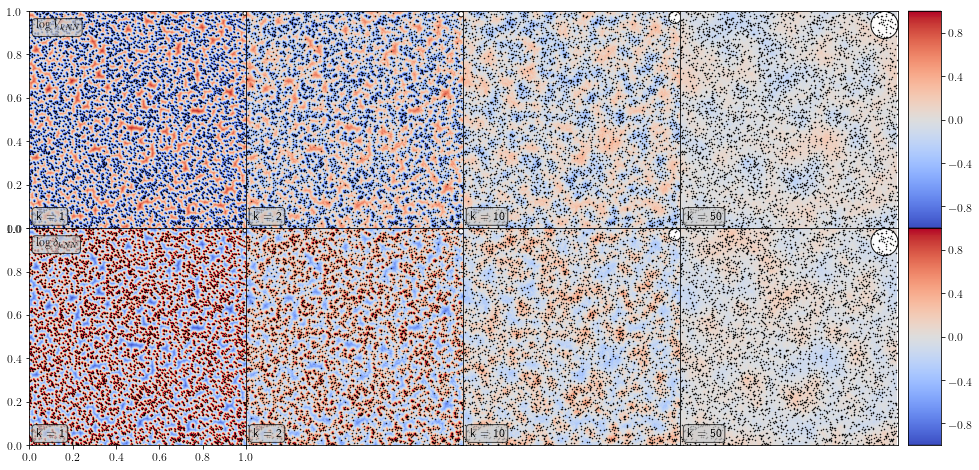

In [7]:
extent = 0.,1-dx, 0, 1-dx
import mpl_toolkits.axes_grid1 as axes_grid1
fig = plt.figure(frameon=False)
grid = axes_grid1.AxesGrid(
    fig, 111, nrows_ncols=(2, len(ks)), axes_pad = 0., cbar_location = "right",
    cbar_mode="edge", cbar_size="15%", cbar_pad="5%",)
bbox = dict(boxstyle="round", fc="0.8", alpha=.7)

for kp in range(len(ks)):
    im0 = grid[kp].imshow(np.log10(vol[:,kp].reshape((uni_Nl,uni_Nl))),\
                          aspect='equal',extent=extent,\
                          origin='lower', cmap='coolwarm',vmin=-1,vmax=1)
    im1 = grid[kp+4].imshow(np.log10(rho[:,kp].reshape((uni_Nl,uni_Nl))),\
                          aspect='equal',extent=extent,\
                          origin='lower', cmap='coolwarm',vmin=-1.,vmax=1)
    grid[kp].set_xlim((0,1))
    grid[kp].set_ylim((0,1))
    grid[kp+4].set_xlim((0,1))
    grid[kp+4].set_ylim((0,1))


    if kp != 0:
        dummy = grid[kp+4].set_xticks([])
    dummy = grid[kp].plot(x[:,0],x[:,1],'k.',ms=1.);
    dummy = grid[kp+4].plot(x[:,0],x[:,1],'k.',ms=1.);

    dummy = grid[kp].annotate('k = '+str(ks[kp]), xy=(.03,.04),bbox=bbox);
    dummy = grid[kp+4].annotate('k = '+str(ks[kp]), xy=(.03,.04),bbox=bbox);
    
    boxsl = np.sqrt(ks[kp]/Npoints/np.pi)
    rect = Circle((1-boxsl,1-boxsl),boxsl)
    pc = PatchCollection([rect], facecolor="white", alpha=.95,
                             edgecolor="black")
    pc2 = PatchCollection([rect], facecolor="white", alpha=.95,
                             edgecolor="black")
    
    grid[kp].add_collection(pc)
    grid[kp+4].add_collection(pc2)




grid[0].annotate('$\log V_{kNN}$', xy=(.03,.91),color='black',bbox=bbox);
grid[4].annotate('$\log \delta_{kNN}$', xy=(.03,.91),color='black',bbox=bbox);

grid.cbar_axes[0].colorbar(im0);
grid.cbar_axes[1].colorbar(im1);

> Figure 1: Visualization of the specific volume $\log_{10}(V_{kNN}({\bf x}))$ for $k=1,\ 2,\ 5,$ and $10$ for a 2D data set with 3000 points drawn from a uniform distribution (a spatial Poisson point process). The overlayed blue dots show the generating point locations. The bottom row shows $\delta_{kNN}=1/V_{kNN}$. On this logarithmic scale the images are identical with the colorbars inverted. For statistical questions, however, we may prefer one over the other depending whether we want to emphasize high densities or large specific volumes. 

Now with these fields generated we may look at their cumulative distribution functions. 

### CDFs and Counts in Cell
With the overdensity and specific volume functions defined we may now look at what their statistics are when applied to samples from a Poisson point process. The cumulative distribution probability function (CDF) and the assoicated survival functions, $1-CDF$, are shown in Figure 2. We use the $600^2=36000$ uniformly spaced samples that made the 600 by 600 images in Figure 1 as our measurements of $V_{kNN}$ for the field generated by the 3000 input  points. Sorting the specific volume values in ascending order and labeling them with their fractional position in the ordered list gives our measured cumulative distribution function. We show the results for $k=1,2,10,50$. We also show the analytical expectations from the Poisson CDF 
$$
CDF_{Pois}(n,V)=e^{-V/\bar{V}_N} \sum_{i=0}^{n}\frac{(V/\bar{V}_N)^i}{i!},
$$
the probability of finding $n$ points in the volume $V/\bar{V}_N$.

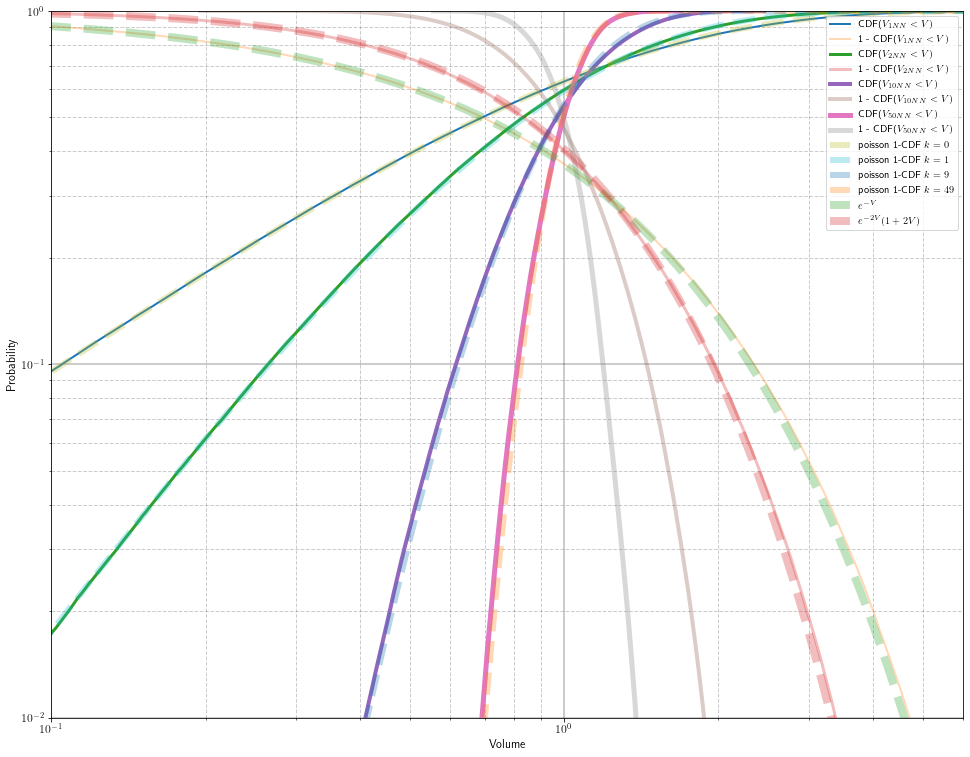

In [8]:
def imCDFVolkNN(vol):
    CDF = vol.copy()
    N = vol.shape[0]
    l = vol.shape[1]
    for c in range(l):
        CDF[:,c] = (1-(np.arange(0, N) + 1) / N)[np.argsort(vol[:,c])]
    return imCDF

def CDFVolkNN(vol):
    CDF = []
    N = vol.shape[0]
    l = vol.shape[1]
    gof = ((np.arange(0, N) + 1) / N)
    for c in range(l):
        ind = np.argsort(vol[:,c])
        sVol= vol[ind,c]
# return array of interpolating functions
        CDF.append(interpolate.interp1d(sVol,gof, kind='linear', \
                                        bounds_error=False))
    return CDF


bine = np.logspace(-4, 3, 1000)
binw = bine[1:] - bine[:-1]
binc = (bine[1:] + bine[:-1]) / 2

cols = ('r','g','b','k')
fig = plt.figure(frameon=False)
# CDF
CDFs = CDFVolkNN(vol)
dummyvpf = 1.-CDFs[0](binc)
dummyvpf[np.isnan(dummyvpf)] = 0
VPF = interpolate.interp1d(binc,dummyvpf,kind='linear', bounds_error=False,fill_value=(0.,0.))

for kp in range(len(ks)):
#    plt.plot(np.sort(vol[:,kp]),(np.arange(Ngp)+1)/Ngp,'.'+cols[kp],label=r"CDF($V_{"+str(ks[kp])+"NN}<V)$", ms=5)
    plt.plot(binc,(CDFs[kp])(binc),'-',lw=2+kp*1.,label=r"CDF($V_{"+str(ks[kp])+"NN}<V)$")
    plt.plot(binc,1-(CDFs[kp])(binc),'-',lw=2+kp*1.,label=r"1 - CDF($V_{"+str(ks[kp])+"NN}<V)$",alpha=.3)

#for kp in range(len(ks)):
#    plt.plot(np.sort(vol[:,kp]),1-(np.arange(Ngp)+1)/Ngp,cols[kp], label=r"1-CDF($V_{"+str(ks[kp])+"NN}<V)$",ms=1.5,alpha=.5)
#plt.plot(np.sort(vol[:,1]*2-vol[:,0]),1-(np.arange(Ngp)+1)/Ngp, 'b.', label=r"($V_{2NN}-V_{1NN}<V)$", ms=1.5,alpha=.005)

plt.plot(binc, 1-poisson.cdf(0,binc), '--', lw=6, alpha=.3, label='poisson 1-CDF $k=0$')
plt.plot(binc, 1-poisson.cdf(1,binc*2), '--', lw=6, alpha=.3, label='poisson 1-CDF $k=1$')
plt.plot(binc, 1-poisson.cdf(9,binc*10), '--', lw=6, alpha=.3, label='poisson 1-CDF $k=9$')
plt.plot(binc, 1-poisson.cdf(49,binc*50), '--', lw=6, alpha=.3, label='poisson 1-CDF $k=49$')

plt.plot(binc, np.exp(-binc),'--',lw=8,alpha=.3, label="$e^{-V}$")
plt.plot(binc, np.exp(-binc*2)*(1+binc*2),'--',lw=8,alpha=.3, label="$e^{-2 V}(1 + 2V)$")
#plt.plot(binc, np.exp(-binc*5)*(1+binc*5+(binc*5)**2/2+(binc*5)**3/6+(binc*5)**4/24),lw=8,alpha=.3)

plt.grid(color='k', linestyle='--', linewidth=1,alpha=.2,which='both',axis='both')
plt.grid(color='k', linestyle='-', linewidth=2,alpha=.2,which='major',axis='both')

plt.xlabel("Volume")
plt.ylabel("Probability")
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-1,6)
plt.ylim(1e-2,1)
plt.legend(loc='upper right',fontsize="small");

> Figure 2: The cumulative distribution function of $V_{kNN}({\bf x})$ and the associated survival functions (1-CDF) for $k=1,\ 2,\ 5,$ and $10$ for a 2D data set with 3000 points drawn from a uniform distribution (a spatial Poisson point process). The lines with crosses are the data and the thick semi-transparent lines show the analytic expectations. $CDF(V_{1NN}<V)$ gives the probability that a volume of size $V$ will be empty is also known as the Void probability function. 

The CDF($V_{1NN}<V$) is the void probability function. It gives the probability whether a random sphere of volume $V$ will be found empty. Similarly CDF($V_{kNN}<V$) give the probability that a random region of Volume $k V$ will contain $k-1$ or fewer points. This makes it clear that differences of these specific volume functions give measurements of what is known as counts in cell, the probability of finding exactly a specific number of points in random regions of a given (cell) size. CIC$_0(V)$, the probability of finding no points in random regions with volume, $V$, is just CDF($V_{1NN}<V$) while, CIC$_n(V)$,the probabilty of finding exactly $n$ in random regions of volume $V$ is then just given by
$$
CIC_n(V) = CDF(V_{(n)NN}<V)-CDF(V_{(n-1)NN}<V)),
$$
for $n\ge 1$.

In [909]:
def CICkNN(xin,xout,kmax, periodic=1):
    CDF = []
    dim = xin.shape[1]
    Ntot = xin.shape[0]
    kneed = np.arange(1,kmax+2)
    print("Calculate these neighbors:",kneed)
    vol = VolumekNN(xin,xout,kneed,periodic=periodic)
    for i in range(1,kmax+1):
        vol[:,i] = vol[:,i]*(i+1)  # need volume not specific volume
    CDFs = CDFVolkNN(vol)
    binc = np.logspace(np.log10(np.min(vol)),np.log10(np.max(vol)),5000)
    CIC = []
    for kst in range(0,kmax):
        vols = binc # CDFs[kst+1].x
        tCIC = CDFs[kst](vols)-CDFs[kst+1](vols)
        tCIC[np.isnan(tCIC)] = 0.
        CIC.append(interpolate.interp1d(vols,tCIC, kind='linear', bounds_error=False,fill_value=(0.,0.)))
# Add the void probability function as the zero counts in cell statistic
    dummyvpf = 1.-CDFs[0](binc)
    dummyvpf[np.isnan(dummyvpf)] = 0
    VPF = interpolate.interp1d(binc,dummyvpf,kind='linear', bounds_error=False,fill_value=(1.,0.))
    CIC = np.insert(CIC,0,VPF)
    return vol, CDFs, CIC
avol, CDFs, CICs = CICkNN(x,xxg,200,periodic=periodic)


Calculate these neighbors: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201]


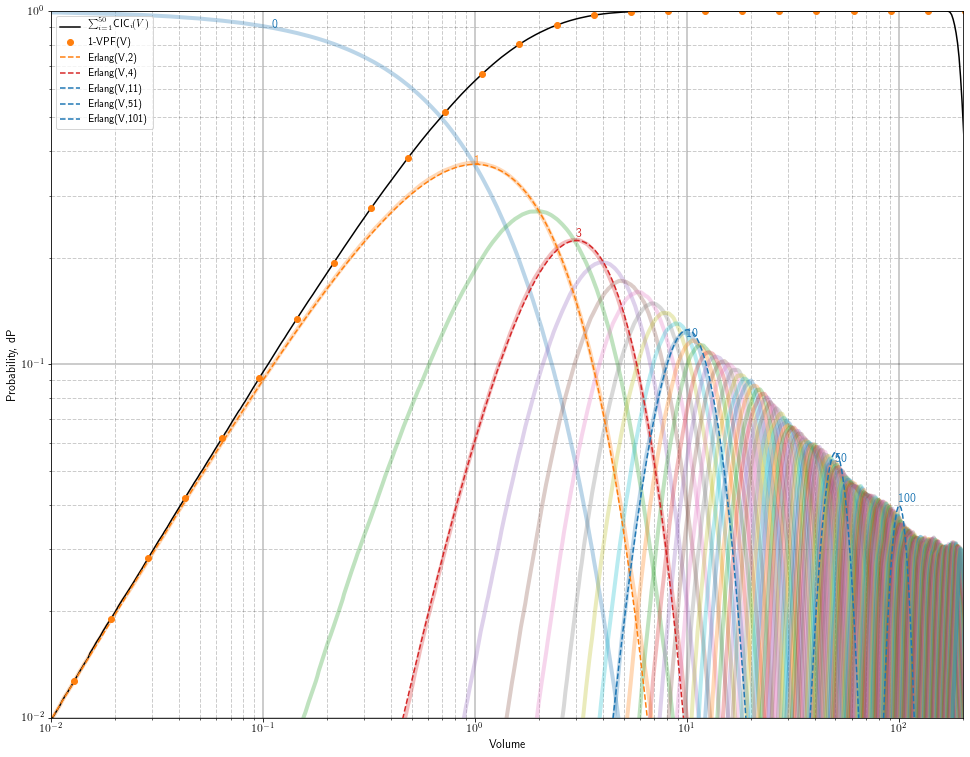

In [910]:
fig = plt.figure(frameon=False)
# CDF
CICtot = np.zeros(len(binc))
for kp in range(0,len(CICs)):
    plt.plot(binc,(CICs[kp])(binc),'-',lw=4,alpha=.3)
#    dummy = (CICs[kp](binc))
#    dummy[np.isnan(dummy)] = 0.
#    CICtot = CICtot + dummy
    if kp != 0:
        CICtot = CICtot + (CICs[kp](binc))
    
plt.plot(binc, CICtot, 'k-', label=r"$\sum_{i=1}^{50} $CIC$_i(V)$")
plt.plot(binc,1.-CICs[0](binc),'o',markevery=25, label="1-VPF(V)")
cols = (plt.rcParams['axes.prop_cycle'].by_key()['color'])

plt.plot(binc,erlang.pdf(binc,2),'--',color=cols[1],label='Erlang(V,2)')
plt.plot(binc,erlang.pdf(binc,4),'--',color=cols[3],label='Erlang(V,4)')
plt.plot(binc,erlang.pdf(binc,11),'--',color=cols[0],label='Erlang(V,11)')
plt.plot(binc,erlang.pdf(binc,51),'--',color=cols[0 ],label='Erlang(V,51)')
plt.plot(binc,erlang.pdf(binc,101),'--',color=cols[0 ],label='Erlang(V,101)')


plt.grid(color='k', linestyle='--', linewidth=1,alpha=.2,which='both',axis='both')
plt.grid(color='k', linestyle='-', linewidth=2,alpha=.2,which='major',axis='both')
plt.annotate('0',xy=(.11,0.9),color=cols[0])
plt.annotate('1',xy=(1,0.37),color=cols[1])
plt.annotate('3',xy=(3,0.23),color=cols[3])
plt.annotate('10',xy=(10,0.12),color=cols[0])
plt.annotate('50',xy=(50,0.053),color=cols[50 % len(cols) ])
plt.annotate('100',xy=(100,0.041),color=cols[100 % len(cols) ])


plt.xlabel("Volume")
plt.ylabel("Probability, dP")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,2e2)
plt.ylim(1e-2,1e0)
plt.legend(loc='upper left',fontsize="small");

> Figure 3: The counts in cell probability density functions, CIC$_i$ measured from the CDFs of $V_{kNN}({\bf x})$ for $i \in [0..100]$  for a 2D data set with 3000 points drawn from a uniform distribution (a spatial Poisson point process). The thick semitransparent lines are the measured counts in cell distributions dashed lines show the analytical Erlang distributions for a few select values as given in the plot legend. The solid black line shows the sum over all CICs which adds up to the non-empty fraction of volumes, i.e. 1- VPF(V). The blue dots show 1-VPF(V) as measured from the CDF of $V_{1NN}$.The drop off of the sum of CICs alrge volumes (black line) stems from the fact that we only add the first 200 counts in cell distributions. 

From Figure 3 we can notice how the point distribution contributes to different scales. If look at a fixed volume we can see which counts contribute at that scale. If we now condition on the contributions to the non-empty regions we can think of the individual CICs as the values of a discrete probability mass function. If we now think of a regions of Volume, $V$, with $n$ points in them has having a number density of $n/V$ the value of CIC$_n(V)$ tells us how to calculate moments of the discrete probability mass functions at each volume (scale). 
$$
\bar{\rho}(V)=E[\rho(V)] = \sum_{i=1}^{N} \frac{i \,\bar{V}}{V}  {\rm CIC}_i(V)
$$
is the mean over density. Using $\rho_i(V)=\frac{i \,\bar{V}}{V}$, the standard deviation is
$$
\sigma = \sqrt{E[\rho(V)^2]} = \sum_{i=1}^{N} \left( \rho_i(V) - \bar{\rho}(V) \right)^2  {\rm CIC}_i(V).
$$ The standardized third moment is the skewness,  
$$
\gamma_1 = E\left[ \left( \frac{\rho(V)-\bar{\rho}(V)}{\sigma} \right)^3\right] = \sum_{i=1}^{N}  \left( \frac{\rho_i(V)-\bar{\rho}(V)}{\sigma} \right)^3 {\rm CIC}_i(V).
$$
The exess kurtosis is 
$$
\kappa_{-3} = -3 +  E\left[ \left( \frac{\rho(V)-\bar{\rho}(V)}{\sigma} \right)^4 \right] = -3 + \sum_{i=1}^{N} \left( \frac{\rho_i(V)-\bar{\rho}(V)}{\sigma} \right)^4 {\rm CIC}_i(V).
$$
All analogously defined higher standardized moments exist and are directly calcuable from the counts in cell probabilities. We will restrict the discussion to these which have names. 

In [915]:
# moments
Nmom = 5
mom = np.zeros((len(binc),Nmom))
smom = np.zeros((len(binc),Nmom))
mom1 = np.zeros((avol.shape[0]))
mom2 = np.zeros((avol.shape[0]))
mom3 = np.zeros((avol.shape[0]))
mom4 = np.zeros((avol.shape[0]))-3. # exess kurtosis

rho  = np.zeros((avol.shape[0],len(CICs)))
Noff = 1
for j in range(Noff,len(CICs)):
    mom[:, 1] = mom[:, 1] + (j/binc)*CICs[j](binc) # mean
    rho[:,j] = ((j+1)/avol[:,j])
    mom1   = mom1 + rho[:,j]
mom1 = mom1/(len(CICs)-Noff)
for j in range(Noff,len(CICs)):
    mom2   = mom2 + (rho[:,j]-mom1)**2
mom2 = mom2/(len(CICs)-Noff)
stdevi = np.sqrt(mom2)    
for j in range(Noff,len(CICs)):
    mom3   = mom3 + ((rho[:,j]-mom1)/stdevi)**3
    mom4   = mom4 + ((rho[:,j]-mom1)/stdevi)**4
mom3 = mom3/(len(CICs)-Noff)
mom4 = mom4/(len(CICs)-Noff)


# moments
for i in range(Nmom):
    if i != 1:
        for j in range(len(CICs)):
            mom[:, i] = mom[:, i] + (j/binc-mom[:,1])**i*CICs[j](binc)
        
stdev = np.sqrt(mom[:,2])
for i in range(3,Nmom):
    if i != 1:
        for j in range(len(CICs)):
            smom[:, i] = smom[:, i] + ((j/binc-mom[:,1])/stdev)**i*CICs[j](binc)

smom[:,4] = smom[:,4] - 3 # exess kurtosis


/Users/tabel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/Users/tabel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide
/Users/tabel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in multiply


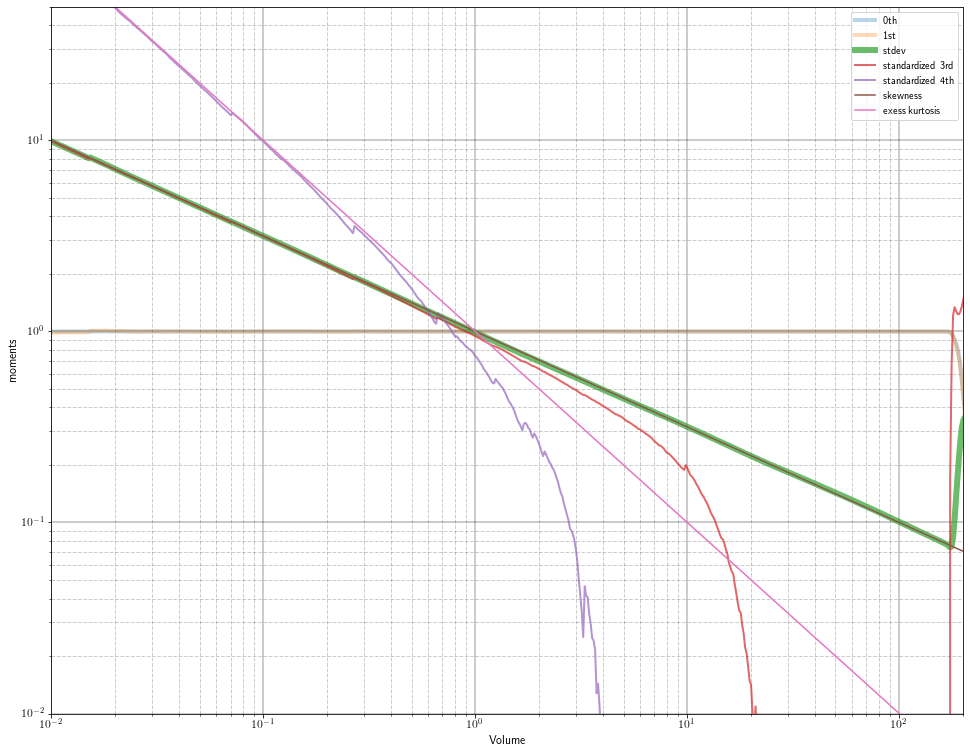

In [916]:
stre = ["th","st","nd","rd","th","th","th","th","th","th","th","th","th","th"]
for i in range(2):
    plt.plot(binc,mom[:,i],'-',lw=4,alpha=.3, label=str(i)+stre[i])

    
plt.plot(binc,stdev,lw=6,alpha=.7,label="stdev")    
for i in range(3,Nmom):
    plt.plot(binc,smom[:,i],'-',lw=2,alpha=.7, label="standardized "+str(i)+stre[i])


mean, var, skew, kurt = poisson.stats(binc, moments='mvsk')
#plt.plot(binc, var, label="variance")
plt.plot(binc, skew, label="skewness")
plt.plot(binc, kurt, label="exess kurtosis")

plt.grid(color='k', linestyle='--', linewidth=1,alpha=.2,which='both',axis='both')
plt.grid(color='k', linestyle='-', linewidth=2,alpha=.2,which='major',axis='both')

plt.xlabel("Volume")
plt.ylabel("moments")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-2,2e2)
plt.ylim(1e-2,5e1)
plt.legend(loc='upper right',fontsize="small");

> Figure 4: Moments of the density distribution of the function of scale. Clearly the first moment, the mean density, is remarkably well recovered to be unity across the full range of volumes. The standard deviations equals the square root N noise we expect for a Poisson distribution of points. The procedure recovers the theoretical skewness expectation with the standardized third moment for a wide range of volumes as well as the excess kurtosis (4th moment). The deviations at large volumes stems from the fact that we only used the nearest neighbor distributions up to $k=200$ and that for the assumed point density not sufficient statistically independent volumes exist in the domain. 

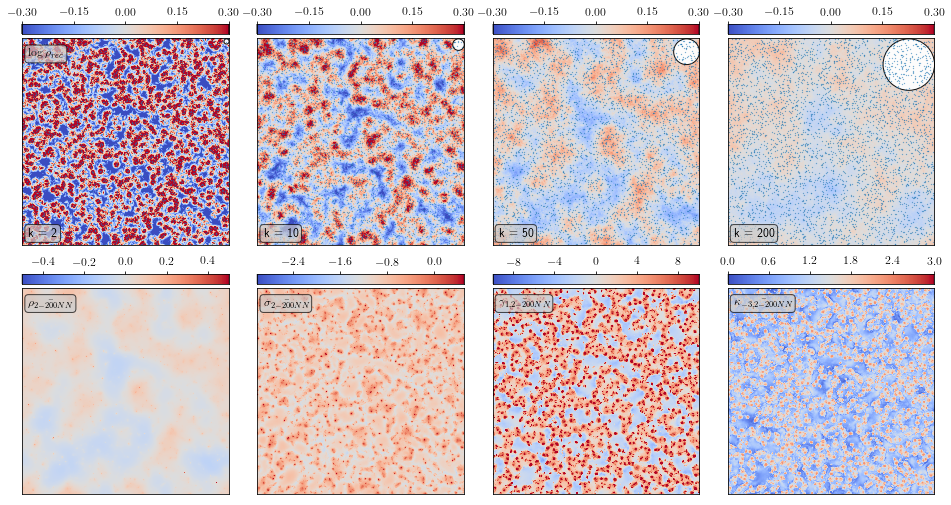

In [913]:
extent = 0,1, 0, 1
import mpl_toolkits.axes_grid1 as axes_grid1
fig = plt.figure(frameon=False)
grid = axes_grid1.AxesGrid(
    fig, 111, nrows_ncols=(2, 4), axes_pad = 0.4, cbar_location = "top",
    cbar_mode="each", cbar_size="5%", cbar_pad="2%",)
bbox = dict(boxstyle="round", fc="0.8", alpha=.7)

ks = [2,10, 50, 200]
for kp in range(len(ks)):
    im0 = grid[kp].imshow(np.log10(rho[:,ks[kp]]).reshape((uni_Nl,uni_Nl)),\
                          aspect='equal',extent=extent,\
                          origin='lower', cmap='coolwarm',vmin=-.3,vmax=.3)


#    if kp != 0:
    dummy = grid[kp+4].set_xticks([])
    dummy = grid[kp+4].set_yticks([])
    dummy = grid[kp].set_yticks([])


    dummy = grid[kp].plot(x[:,0],x[:,1],'.',ms=.5);
#    dummy = grid[kp+4].plot(x[:,0],x[:,1],'.',ms=.5);

    dummy = grid[kp].annotate('k = '+str(ks[kp]), xy=(.03,.04),bbox=bbox);
    boxsl = np.sqrt(ks[kp]/Npoints/np.pi)

    rect = Circle((1-boxsl,1-boxsl),boxsl)


    pc = PatchCollection([rect], facecolor="white", alpha=.95,
                             edgecolor="black")
    
    grid[kp].add_collection(pc)

im4 = grid[4].imshow(np.log10(mom1).reshape((uni_Nl,uni_Nl)),\
                     aspect='equal',extent=extent,\
                     origin='lower', cmap='coolwarm',vmin=-.5,vmax=.5)
im5 = grid[5].imshow(np.log10(np.sqrt(mom2)).reshape((uni_Nl,uni_Nl)),\
                     aspect='equal',extent=extent,\
                     origin='lower', cmap='coolwarm',vmin=-3,vmax=.5)
im6 = grid[6].imshow((mom3).reshape((uni_Nl,uni_Nl)),\
                     aspect='equal',extent=extent,\
                     origin='lower', cmap='coolwarm',vmin=-10,vmax=10)

im7 = grid[7].imshow(np.log10(mom4).reshape((uni_Nl,uni_Nl)),\
                     aspect='equal',extent=extent,\
                     origin='lower', cmap='coolwarm',vmin=0,vmax=3)

dummy = grid[4].annotate(r'$\bar{\rho_{2-200NN}}$', xy=(.03,.91),bbox=bbox);
dummy = grid[5].annotate(r'$\bar{\sigma_{2-200NN}}$', xy=(.03,.91),bbox=bbox);
dummy = grid[6].annotate(r'$\bar{\gamma_{1, 2-200NN}}$', xy=(.03,.91),bbox=bbox);
dummy = grid[7].annotate(r'$\bar{\kappa_{-3,2-200NN}}$', xy=(.03,.91),bbox=bbox);

grid[0].annotate(r'$\log \rho_{rec}$', xy=(.03,.91),color='black',bbox=bbox);
#grid[4].annotate(r'$\log {\rho}^2_{rec}$', xy=(.03,.91),color='black',bbox=bbox);

a = grid.cbar_axes[0].colorbar(im0);

grid.cbar_axes[1].colorbar(im0);
grid.cbar_axes[2].colorbar(im0);
grid.cbar_axes[3].colorbar(im0);

grid.cbar_axes[4].colorbar(im4);
grid.cbar_axes[5].colorbar(im5);
grid.cbar_axes[6].colorbar(im6);
grid.cbar_axes[7].colorbar(im7);

In [881]:
mom3.mean()

1.7335083123607409

(0.0001, 10.0)

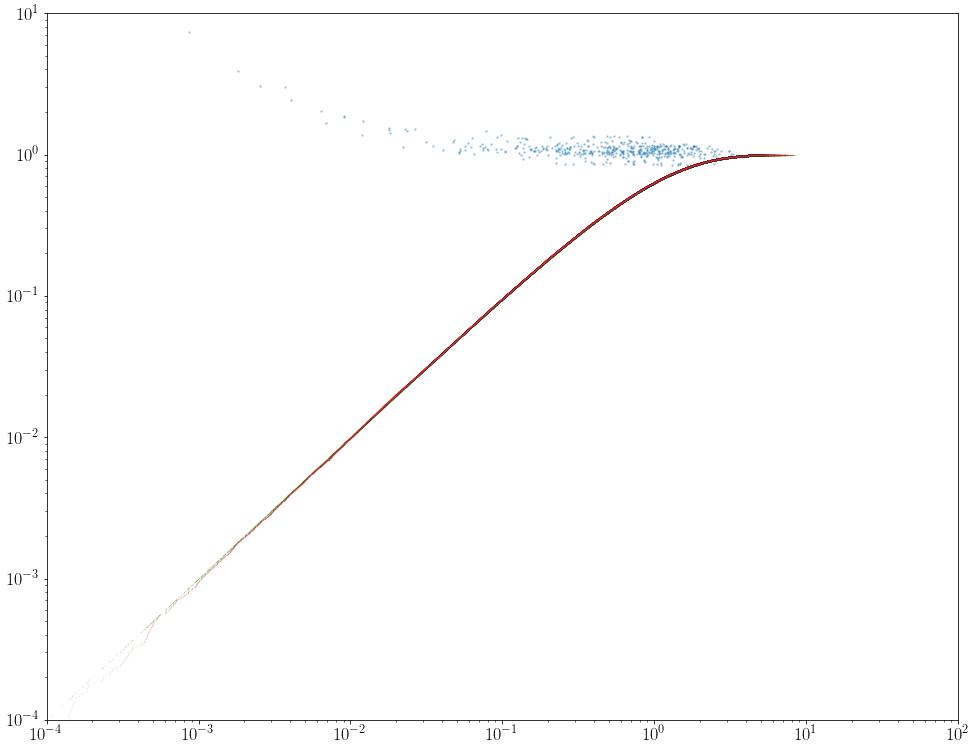

In [836]:
plt.plot(avol[0:500,0], mom1[0:500], '.' ,ms=3,alpha=1.3)
j=0
plt.plot(avol[:,j], (j/avol[:,j])*CDFs[j](avol[:,j])/(1.-poisson.cdf(j,avol[:,j])), '.', ms=.1)
plt.plot(avol[:,j], (1.-poisson.cdf(j,avol[:,j])), '.', ms=.1)
plt.plot(avol[:,j], CDFs[j](avol[:,j]), '.', ms=.1)

plt.xscale('log')
plt.yscale('log')
plt.xlim((1e-4,1e2))
plt.ylim((1e-4,10e0))

In [ ]:
Ngp = len(rho[:,0])

cols = ('r','g','b','k')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
# CDF
for kp in range(len(ks)):
    axes[0].plot(np.sort(rho[:,kp]),(np.arange(Ngp)+1)/Ngp,'.'+cols[kp],label=r"CDF($\rho_{"+str(ks[kp])+"NN}<\rho)$", ms=5)
for kp in range(len(ks)):
    axes[0].plot(np.sort(rho[:,kp]),1-(np.arange(Ngp)+1)/Ngp,cols[kp], label=r"1-CDF($\rho_{"+str(ks[kp])+"NN}<\rho)$",ms=1.5,alpha=.5)
axes[0].set_xlabel(r"$\rho$")
axes[0].set_ylabel("Probability")
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlim(1e-2,10)
axes[0].set_ylim(1e-3,1)

#PDF 
from scipy.special import gamma
def Erlang(k, lam, x):
    if k == 0:
        klamx = lam * x
        gammak = 1
    else:
        klamx = k * lam * x
        gammak = gamma(k)
    return (klamx) ** k / gammak * np.exp(-klamx)

bine = np.logspace(-5, 2, 120)
binw = bine[1:] - bine[:-1]
binc = (bine[1:] + bine[:-1]) / 2

for kp in range(len(ks)):
    hrho = np.histogram(rho[:,kp], bins=bine, density=True)
    axes[1].plot(binc,hrho[0],str(cols[kp])+'x',label=r"$k="+str(ks[kp])+"$")
    axes[1].plot(binc,Erlang(ks[kp]-1,1,binc),str(cols[kp])+'-o',label=r"Erlang($k="+str(ks[kp])+"$)")

    
axes[1].set_xlabel(r"$\rho$")
axes[1].set_ylabel("PDF")
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e-2,10)
axes[1].set_ylim(1e-3,2)

axes[0].legend(loc='upper left',fontsize="x-small");
axes[1].legend(loc='upper left',fontsize="x-small");

## Void Probability Functions and Counts in Cells

We can study its probability density function White (1979) defines $P{\Phi_k(V)}$ as the probability that there are exactly $k$ points in a randomly chosen region of the volume, $V$. 
White (1979) also describes the natural estimator for the Void Probability Function, $P{\Phi_0(V)}$, to be the nearest neighbor counts. 
One chooses a large number, $N_{tot}$, of points in the volume at random. The fraction of these points which have nearest neighbor distances (to nearest galaxy), $r_{1NN}$ , larger than a given radius $r$,  
\begin{equation}
g_{1NN}(r)=\frac{1}{N_{tot}} N(r_{1NN} \gt r),
\end{equation}
is that estimate of the Void Probability Function. 
If we consider the field $V_{1NN}\equiv 1/\rho_{1NN}$, the k-th nearest neighbor volume at ${\bf x}$, we see that $g_{1NN}$ is exactly the numerical estimate of its PDF just expressed as function of radius rather than the volume. 

The generalization to $g_{kNN}(r)$ measuring the fraction of points with $k$ nearest neighbor distances larger than $r$ can hence also be understood as the PDFs of all $V_{kNN}({\bf x})\equiv 1/\rho_{kNN}({\bf x})$. Equally interesting is that we have further be used as an estimator for the counts in cell probabilities.
\begin{equation}
h_{kCIC}(r)=\frac{1}{N_{tot}} N(r_{(k+1)NN} \gt r) - \frac{1}{N_{tot}} N(r_{(kNN} \gt r),
\end{equation}

In [778]:
from scipy import stats

np.random.seed(0)
ox = np.concatenate([stats.cauchy(-5, 1.8).rvs(500),
                    stats.cauchy(-4, 0.8).rvs(2000),
                    stats.cauchy(-1, 0.3).rvs(500),
                    stats.cauchy(2, 0.8).rvs(1000),
                    stats.cauchy(4, 1.5).rvs(500)])
ox = ox[(ox > -15) & (ox < 15)]
inmin = ox.min()
inmax = ox.max()
inscale = inmax-inmin
print("scale by: ",inscale, " inmin:", inmin)

ox = (ox - np.min(ox))/(ox.max()-ox.min())
No = len(ox)

ox = ox.reshape((No,1))
Nog = 300000
Nonei = 400
#ox = np.random.rand(No,1)
oxg = np.linspace(1e-6,1-1e-6, Nog)
oxxg = np.zeros((Nog, 1))
oxxg[:,0] = oxg[:]
xtree = scipy.spatial.cKDTree(ox)
kneed = np.arange(Nonei)+1
dis, disi = xtree.query(oxxg, k=kneed)
ovol = dis*2*No

oCDFs = CDFVolkNN(ovol)

binc = np.logspace(np.log10(np.min(ovol)),np.log10(np.max(ovol)),5000)
CIC = []
for kst in range(0,Nonei-1):
    vols = binc # CDFs[kst+1].x
    tCIC = oCDFs[kst](vols)-oCDFs[kst+1](vols)
    tCIC[np.isnan(tCIC)] = 0.
    CIC.append(interpolate.interp1d(vols,tCIC, kind='linear', bounds_error=False,fill_value=(0.,0.)))
# Add the void probability function as the zero counts in cell statistic
dummyvpf = 1.-CDFs[0](binc)
dummyvpf[np.isnan(dummyvpf)] = 0
oVPF = interpolate.interp1d(binc,dummyvpf,kind='linear', bounds_error=False,fill_value=(1.,0.))
oCIC = np.insert(CIC,0,oVPF)

omom1 = ovol[:,0]*0.
omom2 = ovol[:,0]*0.
orho = np.zeros((ovol.shape[0], Nonei))
for j in range(1,Nonei):
    myisf = interpolate.interp1d(poisson.sf(j,binc),binc, kind='linear', bounds_error=False,fill_value=(0.,0.))
    orho[:,j] = (j)/myisf(oCDFs[j](ovol[:,j]))
    omom1 = omom1 + orho[:,j]

    

omom1 = omom1/(Nonei)
for i in range(1,Nonei):
    omom2 = omom2 + (i/ovol[:,i]-omom1)**2
omom2 = omom2/(Nonei)



scale by:  29.4765945606868  inmin: -14.971369657767438


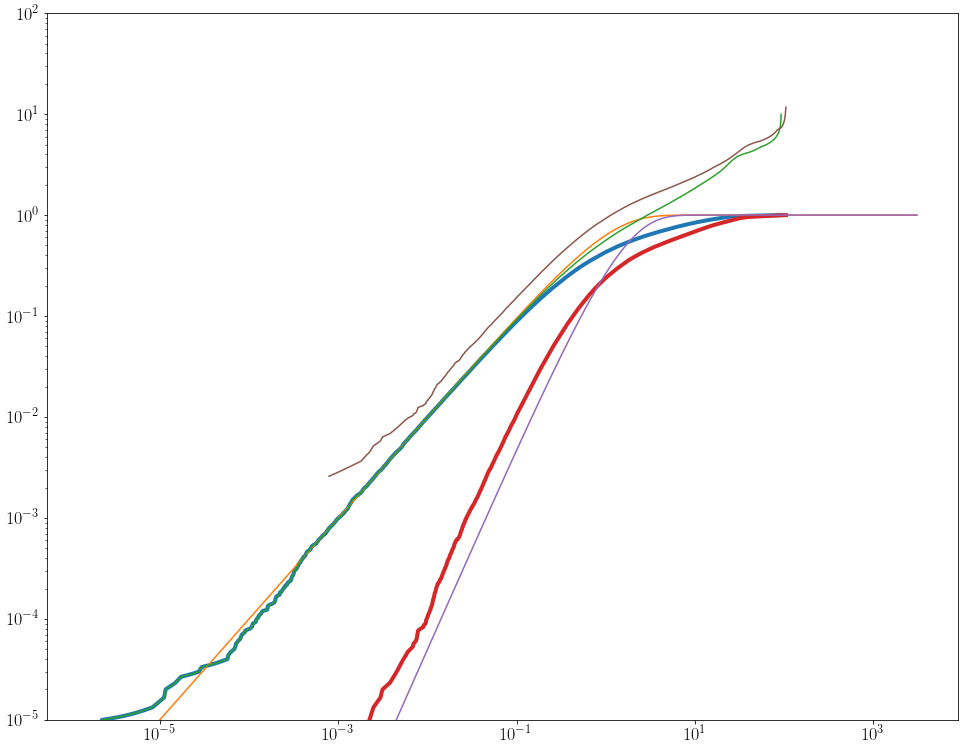

In [779]:
for i in range(0,2):
    plt.plot(binc,oCDFs[i](binc),lw=4)
    myisf = interpolate.interp1d(poisson.sf(i,binc),binc, kind='linear', bounds_error=False,fill_value=(0.,0.))
    plt.plot(binc,poisson.sf(i,binc))
#    plt.plot(binc,myisf(binc))
    plt.plot(binc,myisf(oCDFs[i](binc)))


#    plt.plot(binc,poisson.isf(i,oCDFs[i](binc)))
#    plt.plot(binc,oCDFs[i](binc)/(poisson.sf(i,binc)))

plt.ylim((1e-5,1e2))
plt.xscale("log")
plt.yscale("log")

In [780]:
rv = poisson(1)

(0.0, 5)

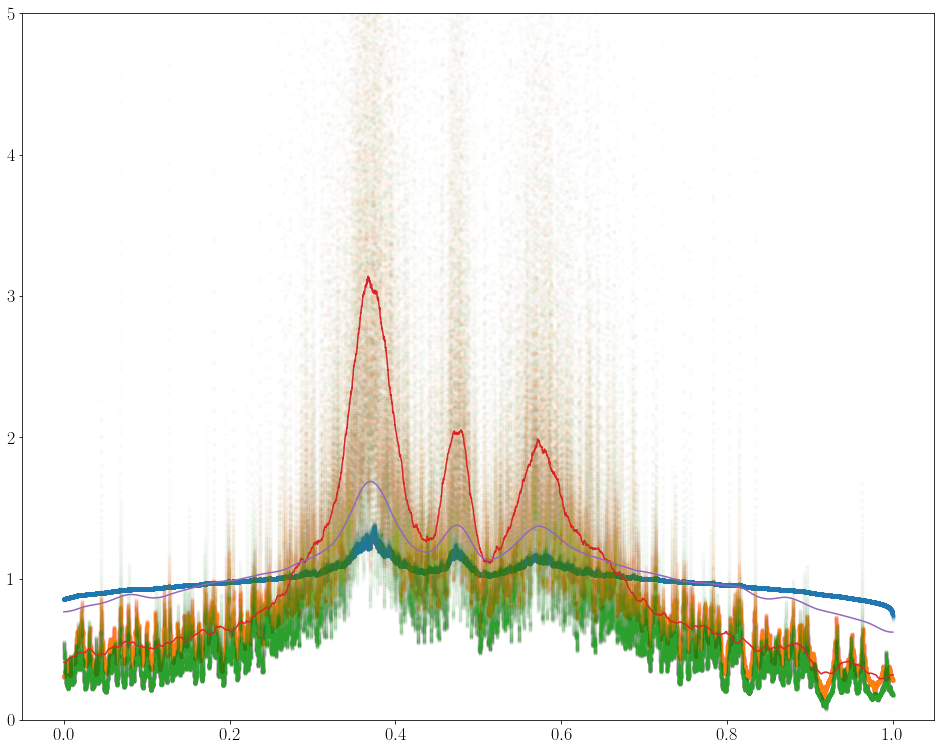

In [781]:
j=0
def smooth(x,window_len=11,window='flat'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """
    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return  y[round((window_len/2-1)):-round((window_len/2))]  # y

srho20 = orho[:,1].reshape((orho.shape[0]))
srho20 = smooth(srho,window_len=10001)
srho2 = orho[:,2].reshape((orho.shape[0]))
srho2 = smooth(srho2,window_len=10001)

#plt.plot(oxxg, oCDFs[j](ovol[:,j]),'.')
#plt.plot(oxxg,(1.-poisson.cdf(j,ovol[:,j])),'.')
plt.plot(oxxg, omom1,'.',alpha=.01)
plt.plot(oxxg, orho[:,2],'.',alpha=.01)
plt.plot(oxxg, orho[:,1],'.',alpha=.01)
plt.plot(oxxg, srho2)
plt.plot(oxxg, srho20)


#plt.plot(oxxg, orho[:,50],'.')
#plt.plot(oxxg, orho[:,150],'.')


#plt.yscale("log")
#plt.xlim(((-15-inmin)/inscale,(15-inmin)/inscale))
plt.ylim((0.,5))

In [753]:
round(10.3)

10

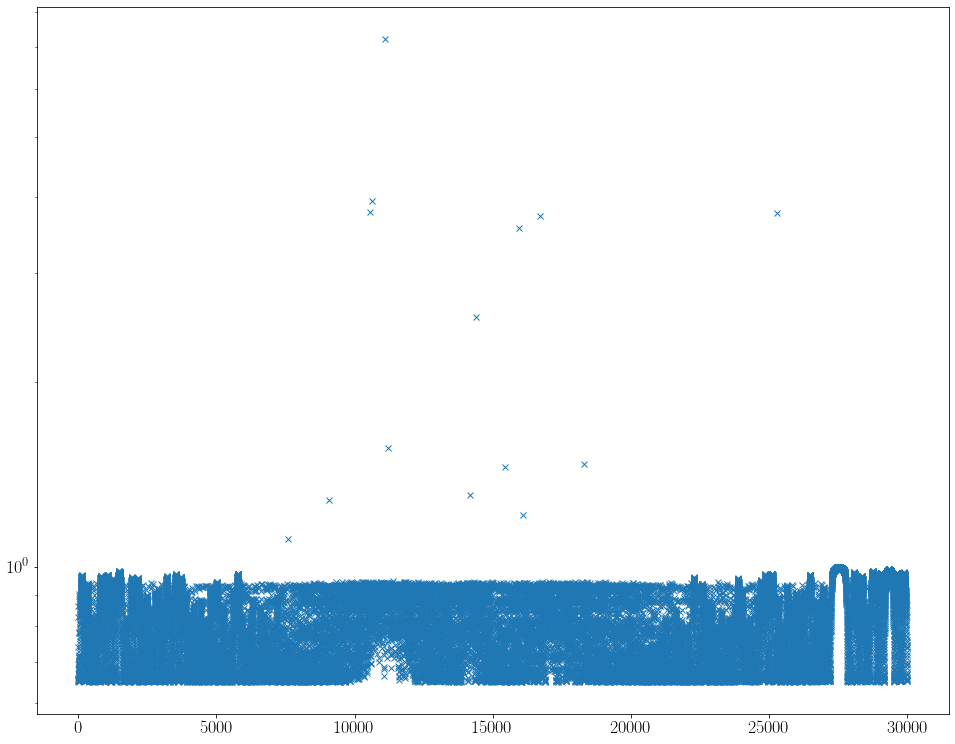

In [632]:
plt.plot(orho[:,0],'x')
plt.yscale("log")
#plt.ylim((0,1))

(-0.000971290702310183, 1.0167853547689165)

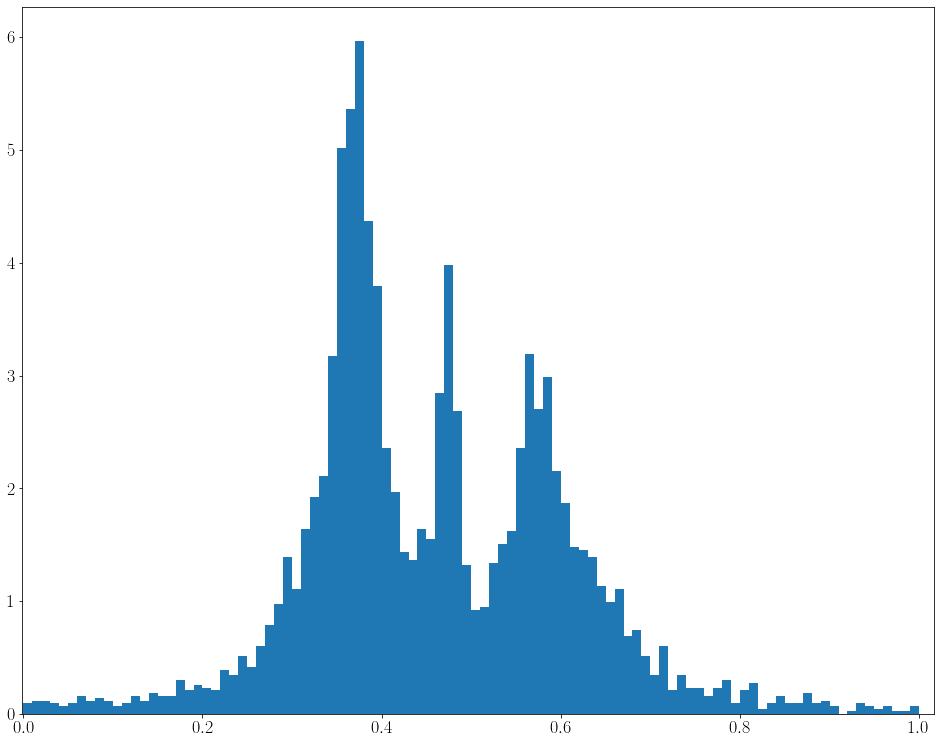

In [569]:

hist(ox, bins=100,  density=True);
plt.xlim(((-15-inmin)/inscale,(15-inmin)/inscale))



In [726]:
orho[:,100].mean()



1.009996204290305

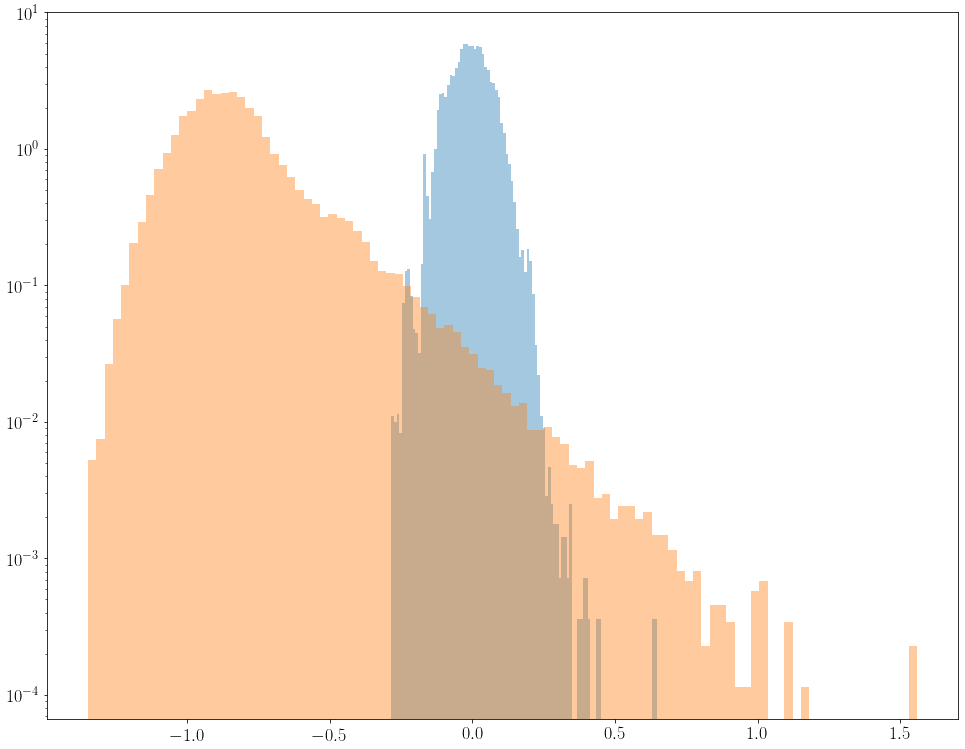

In [371]:
plt.hist(np.log10(omom1),bins=100,log=True,alpha=.4,density=True)
plt.hist(np.log10(np.sqrt(omom2)),bins=100,log=True,alpha=.4,density=True);

In [ ]:

plt.plot()